In [1]:
import openmc
from matplotlib import pyplot as plt

# Advanced OpenMC Geometry

In this module, we'll explore more complex geometry operations and transformations in OpenMC.

Learning objectives:

  - Define a general plane and determine its sense
  - Determine the sense of a general plane
  - Create a lattice Geometry  
  - Cell translations and rotations
  - Define polygon geometry
  - Define axisymmetric geometry

## General Planes

Any three points can be used to define a plane in OpenMC. The positive or negative side of this surface is determined by the plane's normal vector (defined by the coefficients of a, b, and c).

In [2]:
plane = openmc.Plane(a=1.0, b=1.0, c=0.0, d=0.0)
point0 = (2.0, 2.0, 0.0)
print(f'{point0} is on the negative side of the plane: {point0 in -plane}')
point1 = (-2.0, -2.0, 0.0)
print(f'{point1} is on the negative side of the plane: {point1 in -plane}')


(2.0, 2.0, 0.0) is on the negative side of the plane: False
(-2.0, -2.0, 0.0) is on the negative side of the plane: True


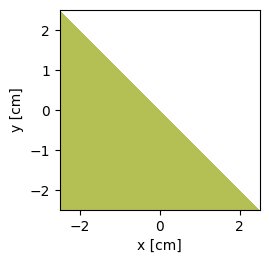

In [3]:
univ = openmc.Universe()
univ.add_cell(openmc.Cell(region=-plane))
univ.plot(width=(5,5))
plt.show()

Flipping the signs of the plane coefficients here produces the same plane, but with opposite positive and negative sides.

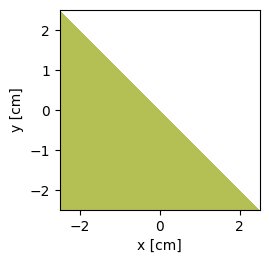

In [4]:
plane = openmc.Plane(a=-1.0, b=-1.0, c=0.0, d=0.0)
cell = openmc.Cell(region=+plane)
univ = openmc.Universe(cells=[cell])
univ.plot(width=(5, 5))
plt.show()

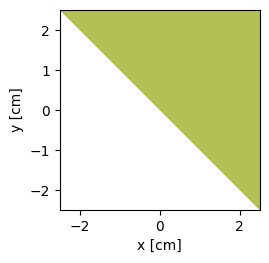

In [5]:
univ = openmc.Universe()
cell = openmc.Cell(region=-plane)
univ.add_cell(cell)
univ.plot(width=(5,5))
plt.show()

# Lattices:

As mentioned in the previous model, `Universe`'s can be used to support duplication of geometry units with the goal of reducing duplicated input and in turn decreasing the likelihood of input errors.

Any cell can be filled with a universe. Like most other Monte Carlo codes, OpenMC contains lattice constructs that structure the replicated geometry for us. In the same way that universes act as a collection of cells, lattices act as a collection of unvierses -- with some spatial structure implied.

OpenMC supports both regular (rectangular) and hexagonal lattice structures. Detailed documentation on these objects can be found [here](https://docs.openmc.org/en/stable/usersguide/geometry.html#lattices).


In [6]:
openmc.RectLattice
openmc.HexLattice

openmc.lattice.HexLattice

# But first: define a quick pincell

We'll define a pincell model to demonstrate some geometry features in OpenMC for use in demonstrating lattice later on.

In [7]:
fuel_or = openmc.ZCylinder(r=0.39)
clad_ir = openmc.ZCylinder(r=0.40)
clad_or = openmc.ZCylinder(r=0.46)
fuel = openmc.Cell(name='fuel', region=-fuel_or)
gap = openmc.Cell(name='air gap', region=+fuel_or & -clad_ir)
clad = openmc.Cell(name='clad', region=+clad_ir & -clad_or)
moderator = openmc.Cell(name='moderator', region=+clad_or)
fuel_pin = openmc.Universe(cells=(fuel, gap, clad, moderator))

Note that the outermost cell, `moderator`, is unbounded.

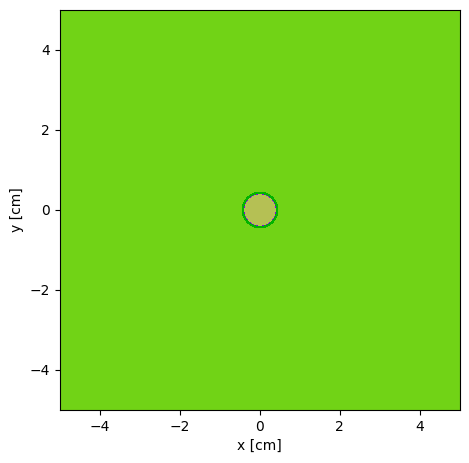

In [8]:
fuel_pin.plot(pixels=(400, 400))
plt.show()

## Lattice Fills

`Lattice`'s create "lattice cells" with a predefined size. `Universe`'s can be used to fill these cells. In this case, we'll replicate our single pincell by filling each lattice cell with the pincell universe we've created above.

We'll start by creating a 2D rectangular lattice with a 2 cm pitch (distance from the center of one lattice cell to the adjacent cell) in both the X and Y directions. OpenMC lattices can replicate geometry in either two or three dimensions. By nature of having two entries, this lattice is 2D. A third entry would be applied to lattice cells in the Z dimension.

In [9]:
lattice = openmc.RectLattice()
lattice.pitch = (2, 2)


We specify which universes are used to fill lattices by populating the lattce's `universes` argument. For a 2D lattice, this is a doubly-nested set of lists where the inner list represents the set of universes for the "X rows" of the lattice. For a 3D, lattice the lists would be triply-nested. The `lower_left` attribute describes where the lattice begins space.

In [10]:
# by nautre of being a 2D lattice, this expects a list of lists
# where each interior
lattice.universes = [[fuel_pin] * 2] * 2
lattice.lower_left = (0, 0)

Now we fill a cell with this lattice and use a universe to generate a plot.

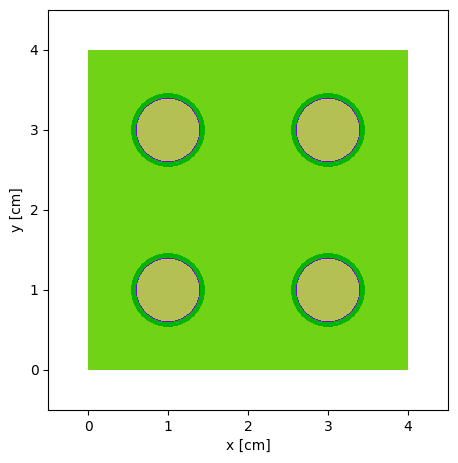

In [11]:

lattice_cell = openmc.Cell(fill=lattice)
lattice_univ = openmc.Universe(cells=[lattice_cell])
lattice_univ.plot(width=(5, 5), origin=(2, 2, 0.0), pixels=(400, 400))
plt.show()

More realistically, we can use the PWR pincell model to create a more meaningful lattice...

In [12]:
# create a 17 by 17 pincell lattice
pitch = 1.26
pincell_lattice = openmc.RectLattice()
pincell_lattice.lower_left = (0, 0)
pincell_lattice.pitch = (pitch, pitch)
pincell_lattice.universes = [[fuel_pin]*17]*17


In [13]:
# define a cell that is filled with the lattice
pwr_lattice_region = -openmc.model.RectangularPrism(
    origin=2*[0.5*17*pitch],
    width=17*pitch,
    height=17*pitch,
    boundary_type='reflective')

pwr_lattice_cell = openmc.Cell(fill=pincell_lattice,
                               region=pwr_lattice_region)
pwr_lattice_univ = openmc.Universe(cells=[pwr_lattice_cell])

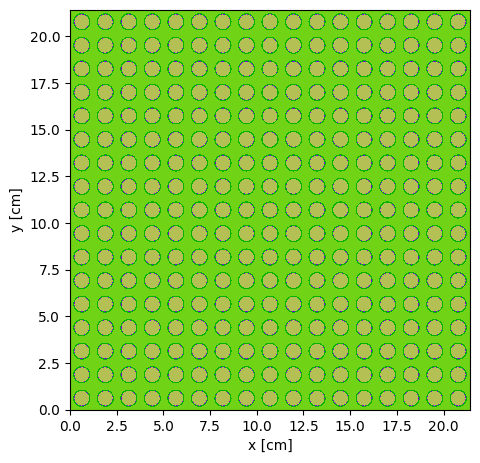

In [14]:
pwr_lattice_univ.plot(pixels=(400, 400))
plt.show()

# Hexagonal Lattices

OpenMC also supports hexagonal lattices. Edges of the lattice can be aligned with either the X or Y axis.

A skewed coordinate system is used for indexing hexagonal lattice tiles. Rather than a y-axis, another axis is used that is rotated 30 degrees counter-clockwise from the y-axis. This axis is referred to as the α-axis. The image below shows how 2D hexagonal tiles are mapped with the (x,α) basis. In this system, (0, 0) maps to the center tile, (0, 2) to the top tile, and (2, -1) to the middle tile on the right side.

<div><img src="https://docs.openmc.org/en/latest/_images/hex_lat.svg" width=400px /> </div>

By nature of the combined-axis system used in hexagonal lattices, a 2D lattice has only one pitch value. The additional pitch parameter represents a pitch in the Z dimension -- the same as it would in the case of a rectangular lattice.

In [15]:
hex_lattice = openmc.HexLattice()
hex_lattice.pitch = (1.26,)

The nesting of universe lists used to set the `universe` attribute is slightly different for hexagonal lattices. These lists should be in order of the **_outermost to innermost ring_** in the lattice. **_Unlike_** the rectangular lattices, the number of universes in each entry is pre-determined based on it's position in the highest level list.

In [16]:
hex_lattice.universes = [[fuel_pin]*12, [fuel_pin]*6, [fuel_pin]]
hex_lattice.center = (0.0, 0.0)

**Note: Both rectungular and hexagonal lattices can be printed for a description of the lattice paramters and unvierse fills**

In [17]:
print(hex_lattice)

HexLattice
	ID             =	9
	Name           =	
	Orientation    =	y
	# Rings        =	3
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(1.26,)
	Outer          =	None
	Universes      
  4
 4 4
4 4 4
 4 4
4 4 4
 4 4
4 4 4
 4 4
  4


Finally, let's plot this lattice to see what it looks like:

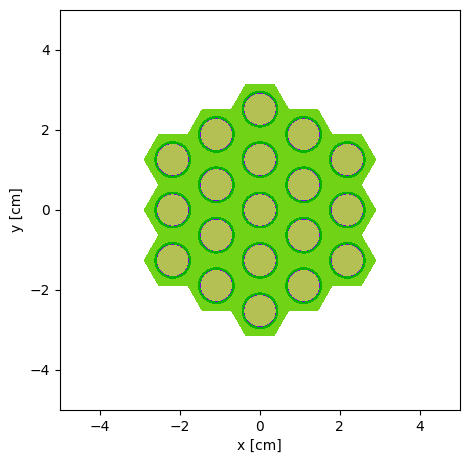

In [18]:
hex_prism = \
    openmc.model.HexagonalPrism(orientation='y',
                                edge_length=3*1.26)
hex_lattice_cell = openmc.Cell(region=-hex_prism, fill=hex_lattice)
hex_universe = \
    openmc.Universe(cells=[hex_lattice_cell])
hex_universe.plot(pixels=(400, 400))
plt.show()

Changing the `orientation` attribute of the lattice gives us a little intuition on it's effects as well.

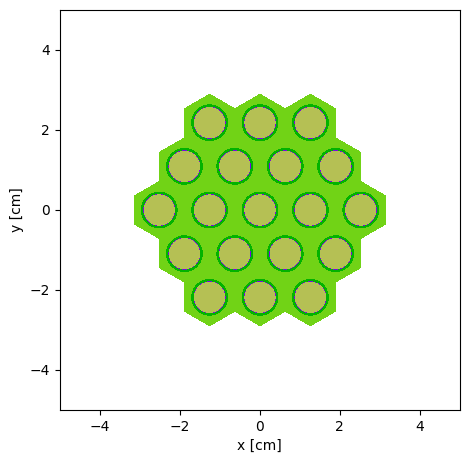

In [19]:
hex_lattice.orientation = 'x'
hex_universe.plot(pixels=(400, 400))
plt.show()

# Universe Fills

Cells can also be filled with universes directly. This allows us to leverage some interesting properties of cells. Namely, translations and rotations.

We'll begin by creating three planes

In [20]:
plane_1 = openmc.Plane(1.0, 1.0, 0.0, 2.5)
plane_2 = openmc.Plane(-1.0, 1.0, 0.0, 2.5)
plane_3 = openmc.Plane(0.0, 1.0, 0.0, 0.0)

Choose the sides of the planes to create a triangle region. Then we'll plot that region using a cell.

In [21]:
triangle_region = -plane_1 & -plane_2 & +plane_3
triangle_cell = openmc.Cell(region=triangle_region)
triangle_univ = openmc.Universe(cells=[triangle_cell])

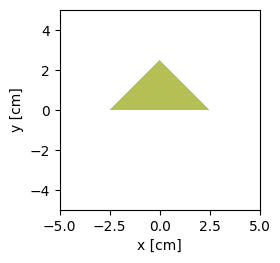

In [22]:
triangle_univ.plot()
plt.show()

Now we can create another cell that is filled with the triangle universe and apply a translation to move the contents inside the new cell.

In [23]:
upper_cell = openmc.Cell(fill=triangle_univ)
upper_cell.translation = (0.0, -5.0, 0.0)
upper_univ = openmc.Universe(cells=[upper_cell])

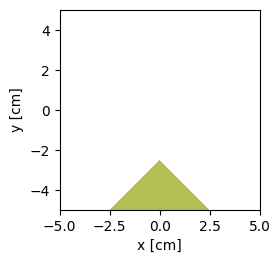

In [24]:
upper_univ.plot()
plt.show()

These contents can be rotated as well. Each entry in the `Cell`'s rotation attribute applies a roatation (in degrees) about the X, Y, and Z axes, respectively. 

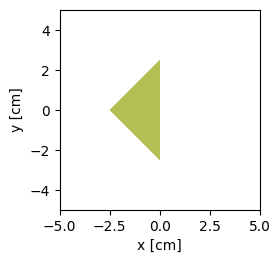

In [25]:
upper_cell.translation = (0, 0, 0)
upper_cell.rotation = (0, 0, 90)
upper_univ.plot()
plt.show()

# Polygon Surfaces

One of OpenMC's [`CompositeSurface`](https://docs.openmc.org/en/stable/pythonapi/model.html?highlight=composite%20surfaces#composite-surfaces)'s is a polygon surface. It allows a set of points defining a ploygon to be built into a surface 


In [26]:
points = [(0.5, 0.0), (0.5, 1.0), (1.0, 1.0), \
          (0.0, 2.0), (-1.0, 1.0), (-0.5, 1.0), (-0.5, 0.0)]
tee_surface = openmc.model.Polygon(points, basis='xy')

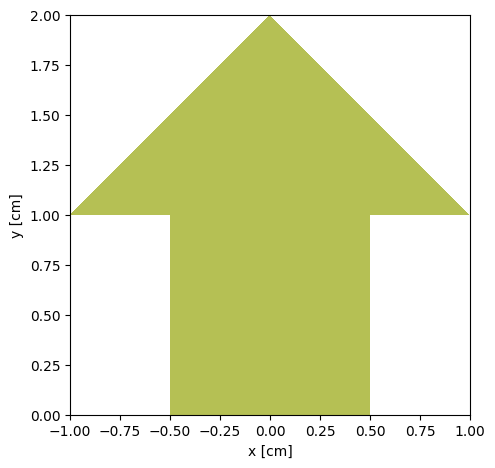

In [27]:
tee_cell = openmc.Cell(region=-tee_surface)
tee_univ = openmc.Universe(cells=[tee_cell])
tee_univ.plot(width=(2, 2),
              origin=(0.0, 1.0, 0.0),
              pixels=(400, 400))
plt.show()

# Axisymmetric Surfaces

Axisymmetric surfaces can be generated as well using a "rz" basis of the `Polygon` composite surface. First, we'll define a profile using an "xy" basis.


In [28]:
points = [(0.1, 2.0), (0.5, 1.5), (0.5, 1.25),
          (0.25, 1.0), (0.5, 0.75), (0.5, 0.5), (0.1, 0.0)]
tee_surface = openmc.model.Polygon(points, basis='xy')

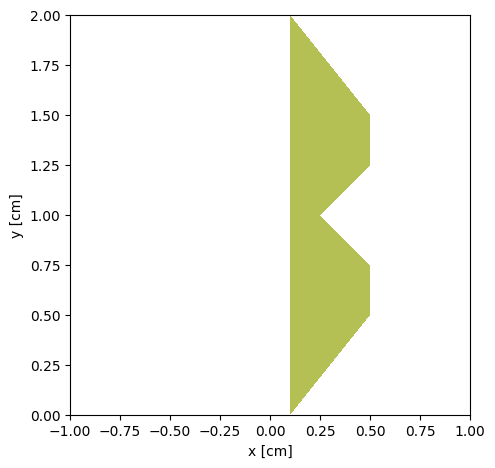

In [29]:
tee_cell = openmc.Cell(region=-tee_surface)
tee_univ = openmc.Universe(cells=[tee_cell])
tee_univ.plot(width=(2, 2),
              origin=(0.0, 1.0, 0.0),
              pixels=(400, 400), basis='xy')
plt.show()

Now we'll change the polygon surface basis to "rz" and plot it in the "xz" plane.

In [30]:
tee_surface = openmc.model.Polygon(points, basis='rz')


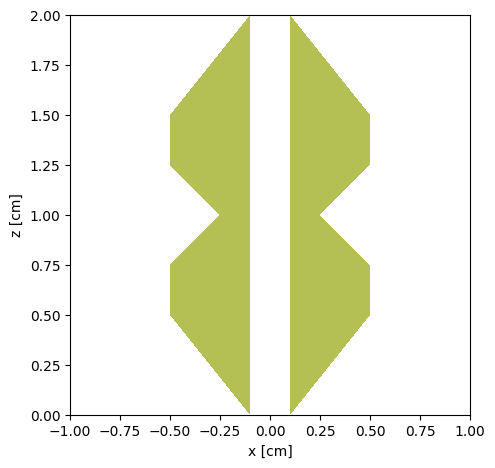

In [31]:
tee_cell = openmc.Cell(region=-tee_surface)
tee_univ = openmc.Universe(cells=[tee_cell])
tee_univ.plot(width=(2, 2),
             origin=(0.0, 0.0, 1.0),
             pixels=(400, 400), basis='xz')
plt.show()

By changing the plot of the surface to the "xy" plane, we can prove to ourselves that this is in fact a revolved surface around the Z axis.

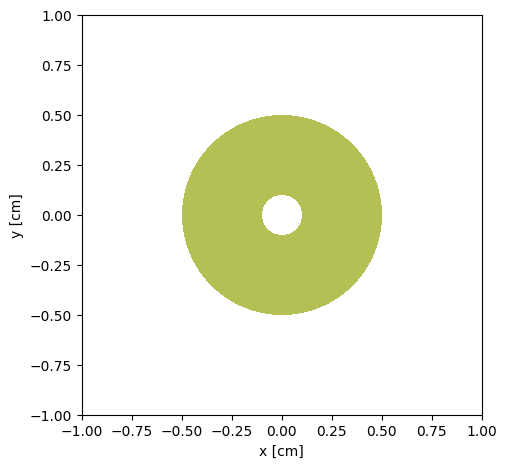

In [32]:

tee_univ.plot(width=(2, 2),
              origin=(0.0, 0.0, 1.5),
              pixels=(400, 400), basis='xy')
plt.show()

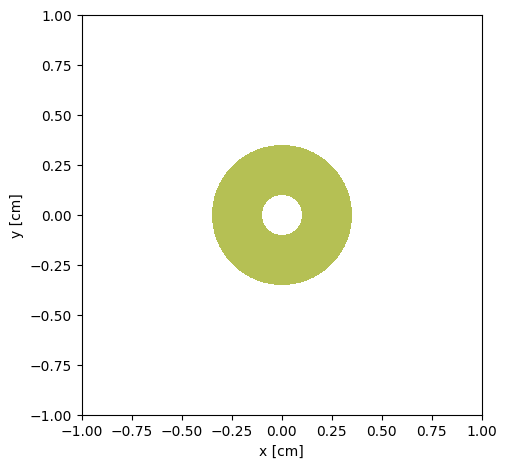

In [33]:

tee_univ.plot(width=(2, 2),
              origin=(0.0, 0.0, 1.1),
              pixels=(400, 400), basis='xy')
plt.show()